<a href="https://colab.research.google.com/github/DJCordhose/ux-by-tfjs/blob/master/notebooks/click-sequence-model.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Training on Sequences of Clicks on the Server

Make sure to run this from top to bottom to export model, otherwise names of layers cause tf.js to bail out

In [1]:
# for colab
!pip install -q tf-nightly-gpu-2.0-preview

     |████████████████████████████████| 369.7MB 53kB/s 
     |████████████████████████████████| 61kB 19.9MB/s 
     |████████████████████████████████| 3.2MB 30.2MB/s 
     |████████████████████████████████| 450kB 42.5MB/s 


In [2]:
import tensorflow as tf
print(tf.__version__)

2.0.0-dev20190701


In [3]:
# a small sanity check, does tf seem to work ok?
hello = tf.constant('Hello TF!')
print("This works: {}".format(hello))

This works: b'Hello TF!'


In [4]:
# this should return True even on Colab
tf.test.is_gpu_available()

True

In [5]:
tf.test.is_built_with_cuda()

True

In [6]:
tf.executing_eagerly()

True

## load data

In [7]:
import pandas as pd
print(pd.__version__)

0.24.2


In [8]:
import numpy as np
print(np.__version__)

1.16.4


In [0]:
# local
# URL = '../data/click-sequence.json'

# remote
URL = 'https://raw.githubusercontent.com/DJCordhose/ux-by-tfjs/master//data/click-sequence.json'


df = pd.read_json(URL, typ='series')

In [10]:
len(df)

26

In [11]:
df.head()

0                                                   []
1                   [train-model, save-model-to-local]
2                      [load-local-model, train-model]
3    [load-local-model, train-model, toggle-visor, ...
4    [train-model, show-eval, train-model, save-mod...
dtype: object

In [12]:
type(df[0])

list

In [13]:
df[0], df[1]

([], ['train-model', 'save-model-to-local'])

In [14]:
all_buttons = set()
for seq in df:
  for button in seq:
    all_buttons.add(button)

all_buttons.add('<START>')
all_buttons.add('<EMPTY>')

all_buttons = list(all_buttons)

print(all_buttons)

['download-model', 'load-local-model', 'toggle-prediction', 'save-model-to-local', 'reset-data', 'toggle-visor', '<EMPTY>', '<START>', 'show-eval', 'upload-model', 'reset-model', 'show-model', 'train-model']


In [15]:
from sklearn.preprocessing import LabelBinarizer, MultiLabelBinarizer, LabelEncoder
encoder = LabelEncoder()
encoder.fit(all_buttons)
encoder.classes_

array(['<EMPTY>', '<START>', 'download-model', 'load-local-model',
       'reset-data', 'reset-model', 'save-model-to-local', 'show-eval',
       'show-model', 'toggle-prediction', 'toggle-visor', 'train-model',
       'upload-model'], dtype='<U19')

In [16]:
transfomed_labels = [encoder.transform(seq) for seq in df if len(seq) != 0]
print(transfomed_labels)

[array([11,  6]), array([ 3, 11]), array([ 3, 11, 10, 10, 11,  5, 11]), array([11,  7, 11,  6]), array([ 3, 11,  7,  6,  2, 10,  9]), array([11,  8, 10,  7, 10, 10,  6,  9]), array([11, 10,  6, 10,  7,  4, 11, 10,  6,  7,  7,  7]), array([11, 11,  6,  7, 10,  9,  6,  2]), array([12, 12, 12, 12,  9]), array([ 4, 11,  9,  7,  9,  9,  9, 10,  9,  9,  5, 11, 10,  6, 11,  6,  7,
        7,  9, 10,  9,  5, 11, 10,  6,  7,  7,  9,  9]), array([11,  6, 10,  2,  9, 12, 12, 10,  7,  7]), array([12, 12,  9,  4,  9]), array([11,  9, 10]), array([11]), array([11,  7,  5, 11, 10, 10, 10,  7,  7, 11,  5, 11,  6,  7,  7,  4,  5,
       11, 10,  7,  7, 10,  5, 11, 10,  6, 10,  9,  9, 11, 10, 10,  9,  9,
       11, 10,  6,  7,  7, 10,  9]), array([11]), array([11]), array([11,  3,  9, 10,  9]), array([ 9,  3,  3,  9,  9,  9, 11, 10, 10,  7,  7,  9, 10, 11]), array([11, 10])]


## pre-process data into chunks

In [0]:
empty = encoder.transform(['<EMPTY>'])
start = encoder.transform(['<START>'])
chunk_size = 5

In [0]:
# [ 1, 11,  7, 11,  6] => [[[0, 0, 0, 0, 1], 11], [[0, 0, 0, 1, 11], 7], [[0, 0, 1, 11, 7], 11], [[0, 1, 11, 7, 11], 6]]

def create_sequences(seq, chunk_size, empty, start):
  # all sequences implicitly start
  seq = np.append(start, seq)
  # if sequence is too short, we pad it to minimum size at the beginning
  seq = np.append(np.full(chunk_size - 1, empty), seq)
  
  seqs = np.array([])
  for index in range(chunk_size, len(seq)):
    y = seq[index]
    x = seq[index-chunk_size : index]
    seqs = np.append(seqs, [x, y])
  return seqs

In [19]:

# seq = transfomed_labels[0]
# seq = transfomed_labels[9]
seq = transfomed_labels[3]
seq

array([11,  7, 11,  6])

In [20]:
create_sequences(seq, chunk_size, empty, start)

array([array([0, 0, 0, 0, 1]), 11, array([ 0,  0,  0,  1, 11]), 7,
       array([ 0,  0,  1, 11,  7]), 11, array([ 0,  1, 11,  7, 11]), 6],
      dtype=object)

In [21]:
seqs = np.array([])
for seq in transfomed_labels:
  seqs = np.append(seqs, create_sequences(seq, chunk_size, empty, start))
seqs = seqs.reshape(-1, 2)
seqs.shape

(167, 2)

In [22]:
X = seqs[:, 0]
# X = X.reshape(-1, chunk_size)
X = np.vstack(X)
X.shape

(167, 5)

In [23]:
y = seqs[:, 1]
y

array([11, 6, 3, 11, 3, 11, 10, 10, 11, 5, 11, 11, 7, 11, 6, 3, 11, 7, 6,
       2, 10, 9, 11, 8, 10, 7, 10, 10, 6, 9, 11, 10, 6, 10, 7, 4, 11, 10,
       6, 7, 7, 7, 11, 11, 6, 7, 10, 9, 6, 2, 12, 12, 12, 12, 9, 4, 11, 9,
       7, 9, 9, 9, 10, 9, 9, 5, 11, 10, 6, 11, 6, 7, 7, 9, 10, 9, 5, 11,
       10, 6, 7, 7, 9, 9, 11, 6, 10, 2, 9, 12, 12, 10, 7, 7, 12, 12, 9, 4,
       9, 11, 9, 10, 11, 11, 7, 5, 11, 10, 10, 10, 7, 7, 11, 5, 11, 6, 7,
       7, 4, 5, 11, 10, 7, 7, 10, 5, 11, 10, 6, 10, 9, 9, 11, 10, 10, 9,
       9, 11, 10, 6, 7, 7, 10, 9, 11, 11, 11, 3, 9, 10, 9, 9, 3, 3, 9, 9,
       9, 11, 10, 10, 7, 7, 9, 10, 11, 11, 10], dtype=object)

## Training

In [24]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Dense, LSTM, GRU, SimpleRNN, Embedding, BatchNormalization, Dropout
from tensorflow.keras.models import Sequential, Model

embedding_dim = 2
n_buttons = len(encoder.classes_)

dropout = .4
recurrent_dropout = .4

model = Sequential()
model.add(Embedding(name='embedding',
                    input_dim=n_buttons, 
                    output_dim=embedding_dim, 
                    input_length=chunk_size))

model.add(SimpleRNN(units=50, activation='relu', name="RNN", recurrent_dropout=recurrent_dropout))
# model.add(GRU(units=25, activation='relu', name="RNN", recurrent_dropout=0.5))
# model.add(LSTM(units=25, activation='relu', name="RNN", recurrent_dropout=0.5))

model.add(BatchNormalization())
model.add(Dropout(dropout))

model.add(Dense(units=n_buttons, name='softmax', activation='softmax'))
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
embedding (Embedding)        (None, 5, 2)              26        
_________________________________________________________________
RNN (SimpleRNN)              (None, 50)                2650      
_________________________________________________________________
batch_normalization (BatchNo (None, 50)                200       
_________________________________________________________________
dropout (Dropout)            (None, 50)                0         
_________________________________________________________________
softmax (Dense)              (None, 13)                663       
Total params: 3,539
Trainable params: 3,439
Non-trainable params: 100
_________________________________________________________________


In [25]:
%%time

EPOCHS = 1000
BATCH_SIZE = 50

history = model.fit(X, y, 
                    batch_size=BATCH_SIZE,
                    epochs=EPOCHS, verbose=0, validation_split=0.2)

W0702 07:11:23.977500 140604897929088 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/ops/math_grad.py:1251: where (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0702 07:11:24.473417 140604897929088 deprecation.py:323] From /usr/local/lib/python3.6/dist-packages/tensorflow_core/python/keras/optimizer_v2/optimizer_v2.py:454: BaseResourceVariable.constraint (from tensorflow.python.ops.resource_variable_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Apply a constraint manually following the optimizer update step.


CPU times: user 1min 19s, sys: 8.43 s, total: 1min 28s
Wall time: 54.4 s


In [26]:
loss, accuracy = model.evaluate(X, y, batch_size=BATCH_SIZE)
accuracy

167/167 [==============================] - 0s 2ms/sample - loss: 1.1218 - accuracy: 0.6587


0.65868264

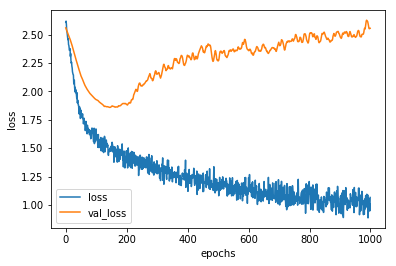

In [27]:
%matplotlib inline

import matplotlib.pyplot as plt

# plt.yscale('log')
plt.ylabel('loss')
plt.xlabel('epochs')

plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])

plt.legend(['loss', 'val_loss'])

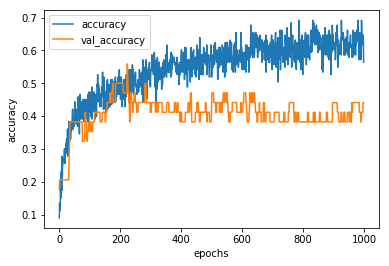

In [28]:
plt.ylabel('accuracy')
plt.xlabel('epochs')

# TF 2.0
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
# plt.plot(history.history['acc'])
# plt.plot(history.history['val_acc'])

plt.legend(['accuracy', 'val_accuracy'])

In [29]:
model.predict([[X[0]]])

array([[3.1764372e-04, 3.1948110e-04, 1.6882364e-03, 1.8360125e-01,
        4.3390695e-02, 7.3930132e-04, 7.7192904e-04, 2.8299938e-03,
        7.4647239e-04, 1.8327440e-03, 3.5560520e-03, 6.6830355e-01,
        9.1902561e-02]], dtype=float32)

In [30]:
model.predict([[X[0]]]).argmax()

11

In [31]:
y[0]

11

In [32]:
y_pred = model.predict([X]).argmax(axis=1)
y_pred

array([11,  7, 11, 11, 11, 11, 10,  6,  7,  5, 11, 11,  7, 10,  6, 11, 11,
       10, 10,  2, 10,  9, 11,  7, 10,  7, 10, 10,  6,  7, 11,  7,  6,  7,
        7,  9, 11, 10,  6,  7,  7,  9, 11,  7,  6,  7,  7,  9,  6,  2, 11,
       12,  9, 12,  9, 11, 11,  9,  7,  9,  9,  9, 10,  9,  9,  9, 11, 10,
        6,  7,  6,  7,  7,  9, 10,  9,  9, 11, 10,  6,  7,  7,  9,  9, 11,
        7,  7,  7,  9, 12, 12, 10,  7,  7, 11, 12,  9,  4,  9, 11,  7, 10,
       11, 11,  7, 10, 11, 10,  6,  7,  7,  7,  7,  5, 11,  6,  7,  7,  9,
       11, 11, 10,  7,  7,  7,  9, 11, 10,  6,  7,  7,  9, 11, 10,  6,  7,
        9,  9, 10,  6,  7,  7,  9,  7, 11, 11, 11,  7, 11, 10,  9, 11, 10,
       11, 11, 10,  9, 12,  9,  6,  7,  7,  7,  9,  9, 11,  7])

In [33]:
y

array([11, 6, 3, 11, 3, 11, 10, 10, 11, 5, 11, 11, 7, 11, 6, 3, 11, 7, 6,
       2, 10, 9, 11, 8, 10, 7, 10, 10, 6, 9, 11, 10, 6, 10, 7, 4, 11, 10,
       6, 7, 7, 7, 11, 11, 6, 7, 10, 9, 6, 2, 12, 12, 12, 12, 9, 4, 11, 9,
       7, 9, 9, 9, 10, 9, 9, 5, 11, 10, 6, 11, 6, 7, 7, 9, 10, 9, 5, 11,
       10, 6, 7, 7, 9, 9, 11, 6, 10, 2, 9, 12, 12, 10, 7, 7, 12, 12, 9, 4,
       9, 11, 9, 10, 11, 11, 7, 5, 11, 10, 10, 10, 7, 7, 11, 5, 11, 6, 7,
       7, 4, 5, 11, 10, 7, 7, 10, 5, 11, 10, 6, 10, 9, 9, 11, 10, 10, 9,
       9, 11, 10, 6, 7, 7, 10, 9, 11, 11, 11, 3, 9, 10, 9, 9, 3, 3, 9, 9,
       9, 11, 10, 10, 7, 7, 9, 10, 11, 11, 10], dtype=object)

In [34]:
# TF 2.0
cm = tf.math.confusion_matrix(labels=tf.constant(y, dtype=tf.int64), predictions=tf.constant(y_pred, dtype=tf.int64))
cm

<tf.Tensor: id=33510, shape=(13, 13), dtype=int32, numpy=
array([[ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0,  0],
       [ 0,  0,  2,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  1,  4,  0],
       [ 0,  0,  0,  0,  1,  0,  0,  0,  0,  2,  0,  1,  0],
       [ 0,  0,  0,  0,  0,  2,  0,  0,  0,  3,  1,  1,  0],
       [ 0,  0,  0,  0,  0,  0, 12,  2,  0,  0,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0, 24,  0,  1,  1,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  1,  0,  0,  0,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  6,  0, 20,  1,  3,  0],
       [ 0,  0,  0,  0,  0,  0,  4,  8,  0,  3, 18,  0,  0],
       [ 0,  0,  0,  0,  0,  0,  0,  4,  0,  2,  1, 26,  1],
       [ 0,  0,  0,  0,  0,  0,  0,  0,  0,  1,  0,  2,  5]], dtype=int32)>

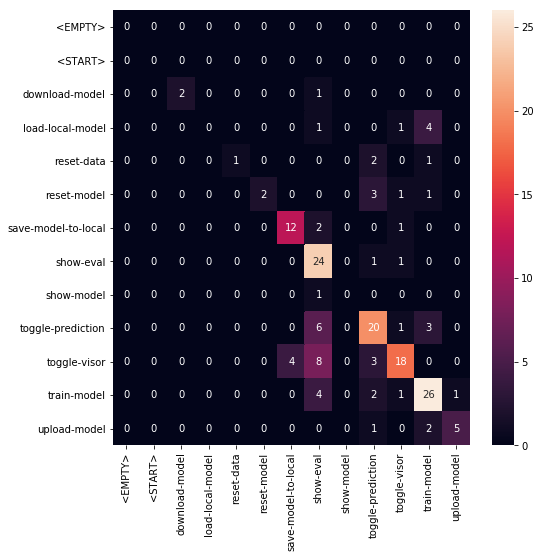

In [35]:
import seaborn as sns

classes = encoder.classes_

plt.figure(figsize=(8, 8))

sns.heatmap(cm, annot=True, fmt="d", xticklabels=classes, yticklabels=classes)

In [0]:
# sns.heatmap?

In [0]:
# import numpy as np

# samples = [1,2,3,4]

# embedding_layer = model.get_layer('embedding')
# embedding_model = Model(inputs=model.input, outputs=embedding_layer.output)
# embeddings_1d = embedding_model.predict(samples).reshape(-1)

# # for printing only
# # plt.figure(figsize=(20,5))
# # plt.figure(dpi=600)

# plt.axis('off')

# plt.scatter(embeddings_1d, np.zeros(len(embeddings_1d)))
# for index, x_pos in zip(samples, embeddings_1d):
#   name = encoder.classes_[index]
#   print(name, (x_pos))
# #   plt.annotate(name, (x_pos, 0), rotation=80)

## Convert Model into tfjs format

In [0]:
model.save('ux.h5', save_format='h5')

In [39]:
!ls -l

total 88
drwxr-xr-x 1 root root  4096 Jun 18 16:14 sample_data
-rw-r--r-- 1 root root 83072 Jul  2 07:12 ux.h5


In [40]:
!pip install -q tensorflowjs

     |████████████████████████████████| 81kB 6.0MB/s 
ERROR: s3fs 0.2.1 has requirement six>=1.12.0, but you'll have six 1.11.0 which is incompatible.
ERROR: jupyter-console 6.0.0 has requirement prompt-toolkit<2.1.0,>=2.0.0, but you'll have prompt-toolkit 1.0.16 which is incompatible.
ERROR: google-colab 1.0.0 has requirement six~=1.12.0, but you'll have six 1.11.0 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: albumentations 0.1.12 has requirement imgaug<0.2.7,>=0.2.5, but you'll have imgaug 0.2.9 which is incompatible.


In [0]:
!tensorflowjs_converter --input_format keras ux.h5 tfjs

In [42]:
!ls -l tfjs

total 20
-rw-r--r-- 1 root root 14156 Jul  2 07:12 group1-shard1of1.bin
-rw-r--r-- 1 root root  3734 Jul  2 07:12 model.json


Download using _Files_ menu on the left